[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/prokaj/elte-python/blob/main/11-gyakorlat.ipynb)

# Házi feladatok

## Polygon osztály további metódusai.

A gyakorlaton látott `Polygon` osztályt egészítsük ki egy `is_inner` metódussal, ami egy tetszőleges síkbeli pontról eldönti, hogy a polygon belsejében van-e (a visszatérési érték `bool` típusú, `True` vagy `False`). Egy egyszerű algoritmus ennek eldöntésére a következő. Indítsunk ki egy félegyenest az adott pontból. Számoljuk meg, hogy hányszor metszi a polygont. Mivel a félegyenes ,,vége” a polygon külsejéhez tartozik és minden átmetszéssel egyik oldalról átkerülünk a mások oldalra ezért a metszések számának paritása megadja, hogy melyik oldalon vagyunk. Amire oda kell figyelni, az az hogy ha félegyenes tartalmazza valamelyik élet, akkor a fenti érvelés nem korrekt!

Emellett implementáljuk az `is_polygon` metódust, ami ellenőrzi, hogy a polygon csúcsai között nincsennek ismétlődések és a különböző élek nem metszik egymást belső pontban. Az `__init__` metódus egészítsük ki ellenőrzéssel, ha a kapott csúcs sorozatot nem tekinthető polygonnak dobjon hibát!

Ellenőrzésképpen készítsünk néhány polygont, legyen köztük konvex és nem konvex is és rajzoljuk a `Polygon` típus `draw` metódusával. Az ábra tartalmazzon egy választott pontot a belőle kiinduló félegyenes alkalmas darabjával és a metszéspontokkal.


In [352]:
import math
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt

def Point(x, y):
    return np.array([x,y])

Vec = Point

class Polygon:

    def __init__(self, nodes):
        self.nodes = nodes
        if not self.is_polygon():
            raise ValueError('Not a polygon')

    def area(self):
        if self.is_convex():
            nodes = np.array(self.nodes)
            nodes = nodes-nodes[0]
            area = 0
            for v1, v2 in zip(nodes[1:], nodes[2:]):
                area += abs(v1[0]*v2[1]-v1[1]*v2[0])
            return area
        else:
            raise NotImplementedError
            

    def perimeter(self):
        total = 0
        for i, p in enumerate(self.nodes, 1):
            j = i % len(self.nodes)
            total += np.linalg.norm(self.nodes[j]-p)
        return total

    def is_convex(self):
        nodes = np.array(self.nodes + self.nodes[:1])
        edges = np.diff(nodes, axis=0)
        idx = np.array([ i % len(edges) for i in range(1, len(edges)+1) ])
        edges1 = edges[idx]
        sgn = (rotate90(edges) * edges1).sum(axis=1)
        return (min(sgn)*max(sgn)>=0)

    def draw(self, *args, fill=False, **kwargs):
        for i, p0 in enumerate(self.nodes):
            p1 = self.nodes[(i+1) % len(self.nodes)]
        x, y = np.concatenate((self.nodes, self.nodes[:1]), axis=0).T
        if fill:
            plt.fill(x, y, alpha=0.5)
        plt.plot(x, y, *args, **kwargs) 
        plt.axis('equal')
    
    def __repr__(self):
        return f'{type(self).__name__}({[tuple(x) for x in self.nodes]})'

    def is_polygon(self):
        return True

    def edge_lines(self):
        for i, p in enumerate(self.nodes):
            next_p = self.nodes[(i+1) % len(self.nodes)]
            yield Line(p, next_p-p)

    def is_inner(self, point, return_line=False):
        
        edges = list(self.edge_lines())
        while True:
            line = Line(point, np.random.normal(size=2))
            
            while any(line.is_parallel(edge) for edge in edges):
                line = Line(point, np.random.normal(size=2))
            
            t_values =[edge.intersection(line) for edge in edges]
            
            if all(not zero_or_one(t) for (t, s) in t_values):
                break
        
        # print(f"{t_values=}")
        points = [edge.point(t) for edge, (t, s) in zip(edges, t_values) if (0<t<1) and (s>=0)]
        is_inner = not is_even(len(points)) 
        
        if return_line:
            return is_inner, line, points
        
        return is_inner


def rotate90(x):
    return np.flip(x, -1)*np.array([-1, 1])

class Rectangle(Polygon):
    
    def __init__(self, P1, P2, r):
        """
        Assuming that e is P1P2 rotated counterclockwise by 90 degree
        P1, P2, P2+r e, P1+re
        """
        v = rotate90(P2-P1)*r
        super(Rectangle, self).__init__([P1, P2, P2+v, P1+v])
        
    
class Square(Rectangle):

    def __init__(self, P1, P2):
        super(Square, self).__init__(P1, P2, 1)

def is_even(n):
    return bool(n%2==0)

def zero_or_one(t: float) -> bool:
    return (t==0) or (t==1)

class Line:
    
    def __init__(self, p: np.ndarray, e: np.ndarray):
        if (e==0).all():
            raise ValueError
        self.p = p
        self.e = e

    def is_parallel(self, other) -> bool:
        return np.linalg.det(np.stack((self.e, other.e))) == 0
    
    def intersection(self, other) -> float:
        if self.is_parallel(other):
            return float(np.Inf)
        a = np.column_stack((self.e, -other.e))
        b = other.p - self.p
        return np.linalg.solve(a, b)
    
    def point(self, t: float):
        return self.p + t*self.e
    
    def draw(self, half_line=False):
        if not half_line:
            plt.axline(self.p, self.p+self.e)
        else:
            x0, x1 = plt.xlim()
            y0, y1 = plt.ylim()
            for edge in [
                Line(Point(x0, y0), Vec(0,y1-y0)),
                Line(Point(x1, y0), Vec(0,y1-y0)),
                Line(Point(x0, y0), Vec(x1-x0,0)),
                Line(Point(x0, y1), Vec(x1-x0,0))                
            ]:
                t, s = self.intersection(edge)
                if t>0 and (0<=s<=1):
                    break
            p = edge.point(s)

            plt.plot(*np.stack((self.p, p), axis=1) )
            plt.xlim(x0, x1)
            plt.ylim(y0, y1)
        
        



In [32]:
try:
    import ipytest
    ipytest.autoconfig()
except ModuleNotFoundError:
    ! pip install ipytest

Célszerű ellenőrizni, jól működik-e a `Line` osztály.

In [110]:
%%ipytest

def test_Line():
    p0 = np.array([1,0])
    p1 = np.array([0,1])
    l0 = Line(p0, p1)
    l1 = Line(p1, p1)
    l2 = Line(p1, p0)
    assert l0.is_parallel(l1) == True
    assert l0.is_parallel(l2) == False
    assert tuple(l0.intersection(l2)) == (1, 1)

.                                                                                            [100%]
1 passed in 0.01s


is_inner=True, len(points)=1


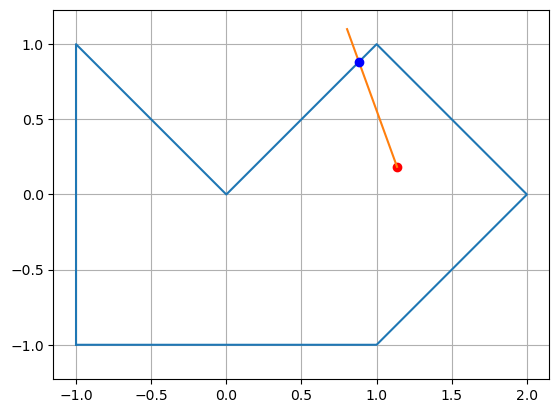

In [348]:
nodes = np.array([[0,0], [2,0], [3, 1], [2,2], [1,1], [0,2]]) - np.array([1,1])
p1 = Polygon(list(nodes))
p1.draw()
p = np.random.normal(size=2)
plt.plot(*p, 'or')
is_inner, line, points = p1.is_inner(p, True)
print(f"{is_inner=}, {len(points)=}")
line.draw(True)
if len(points)>0:
    plt.plot(*np.stack(points,axis=1), 'ob')
plt.grid()
plt.show()

Írjuk meg az `is_polygon` metódust

# Futási idő mérése

Korábban láttunk néhány lehetőséget.

- `%%time`  cella `magic command` jupyter notebookban az eredmények mellé kiírja a **cella** végrehajtáshoz szükséges időt.
- `%time` sor `magic command` jupyter notebookban kiírja a **sor** végrehajtáshoz szükséges időt.
- `%timeit` sor `magic command` a sorban levő kifejezést sokszor kiértékeli a futási időkből készült statisztikát kiírja
- `time.time` vagy `time.perf_counter_ns` a futási idő mérésére használható


A `timeit` nem csak mágikus parancsként érhető el.

In [454]:
import time
import timeit
import math
import matplotlib.pyplot as plt


A következő csak illusztráció. Annak hogy 101-szer ismételjük, hogy egy 10 hosszú ciklusban az `np.logaddexp` függvényt nincs jelentősége. 

In [463]:
def measure_time(k):
    timer = timeit.Timer(
        stmt = 'np.logaddexp(0, x)',
        globals = {
            'np': np,
            'x': np.random.normal(size=(k,k))
        }
    )
    return timer.repeat(101, 10)

time_data = np.array([measure_time(k) for k in range(16, 257, 16)])
print(time_data.shape)


(16, 101)


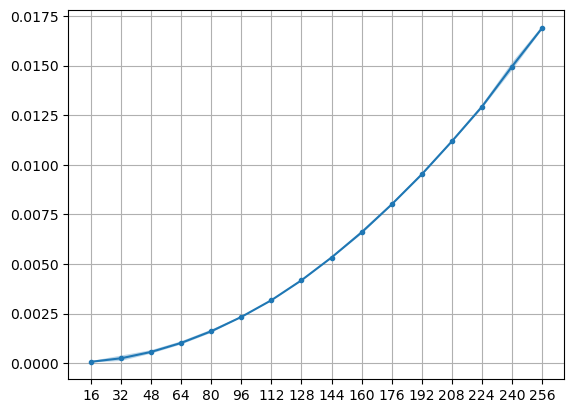

In [469]:

mu = time_data.mean(axis=1)
sigma = time_data.std(axis=1)

plt.plot(range(16,257,16), mu, 'o-', markersize=3)

plt.fill_between(range(16,257,16), mu-2*sigma, mu+2*sigma, alpha=0.3)

plt.xticks(range(16,257,16))

plt.grid()


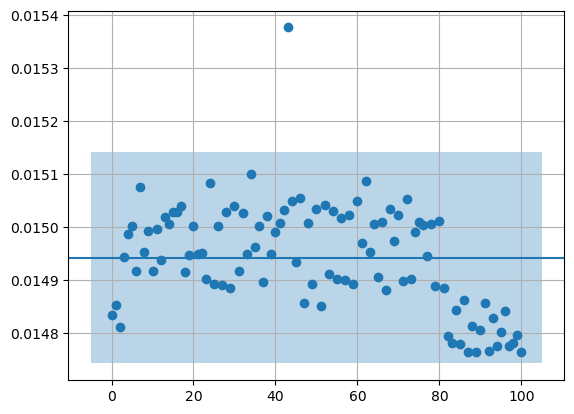

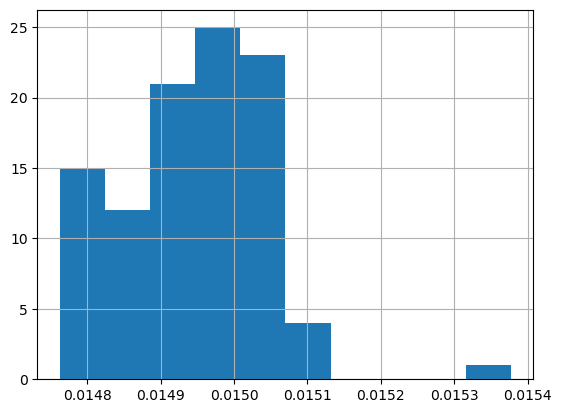

In [472]:
k = 14
plt.plot(time_data[k], 'o')
plt.axhline(mu[k])

plt.fill_between(x=plt.xlim(), y1=mu[k]-2*sigma[k], y2=mu[k]+2*sigma[k], alpha=0.3)
#plt.axhline(mu[k]+2*sigma[14])  
#plt.axhline(mu[k]-2*sigma[14])
plt.grid()
plt.show()
plt.hist(time_data[k])
plt.grid()
plt.show()

Tegyük fel, hogy lépések számát szeretnénk egy függvényen belül megszámolni.
```
def f(k):
    ...
    while cond:
        ...
    
    return ...
```

Nem biztos, hogy a következő a legszebb megoldás, de használható anélkül, hogy két példányban kellene a 
függvényt megírni:
```
def f(k, fake_cond=lambda:True):
    ...
    while cond and fake_cond():
        ...
    return ...
```
Ha `f(k)` alakban hívjuk meg, akkor a korábbi számolás történik. Ha azonban
```
class Count:
    def __init__(self):
        self.cnt = 0
    def __call__(self):
        self.cnt +=1
        return True

counter = Count()
f(k, counter)
counter.cnt
```
akkor visszakapjuk a lépések számát, pontosabban hányszor hajtottuk végre a while ciklus törzsét. 

Példaként nézzük meg, intervallum felezéssel hány lépés alatt jutunk el $f(x)$  közelébe, mondjuk $10^{-6}$ relatív pontossággal, ahol $x\geq 0$, $f$ a $g$ inverze a pozitív félegyenesen és $g(x)=x\arctan(x)$. 
A relatív pontosság itt azt jelenti, hogy ha $y$ a hívás eredménye, akkor $y*(1-10^{-6})<=f(x)<=y*(1+10^{-6})$. 

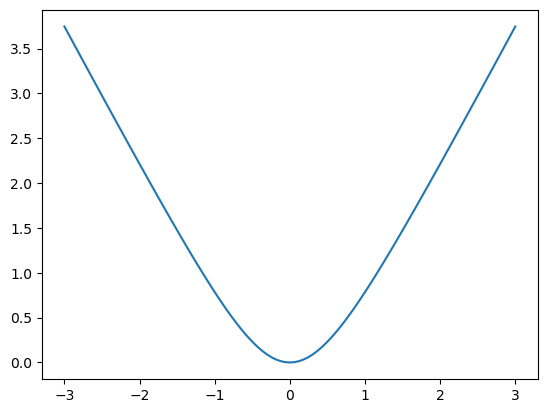

In [483]:
def g(x):
    return x*np.arctan(x)

x = np.linspace(-3, 3, 101)
plt.plot(x,g(x))

In [517]:
eps = 1e-12

def g(x):
    return x*math.atan(x)

def f(x, cond=lambda: True):
    if x <0:
        raise ValueError
    if x == 0:
        return 0

    x1, y1 = x, g(x)
    x0, y0 = 0, g(0)  
    y = x
    xmid = (x0+x1)/2
    while ((x1-x0)> (eps*max(1, xmid))) and cond():
        ymid = g(xmid)
        if ymid>y:
            x1, y1 = xmid, ymid
        else:
            x0, y0 = xmid, ymid
        xmid = (x0+x1)/2
    return xmid

In [518]:
%%ipytest

def g(x):
    return x*math.atan(x)
    
def test_f():
    for y in np.linspace(0, 1000, 20):
        x = f(y)
        x0, x1 = x*(1-eps), x*(1+eps)
        assert g(x0)<=y<=g(x1)



.                                                                                            [100%]
1 passed in 0.01s


Számoljuk meg a szükséges lépések számát!

In [519]:
from functools import wraps
class Count:
    def __init__(self):
        self.cnt = 0
    def __call__(self):
        self.cnt += 1
        return True

def with_counts(f):
    @wraps(f)
    def _f(k):
        cnt = Count()
        result = f(k, cnt)
        return result, cnt.cnt
    return _f

f = with_counts(f)




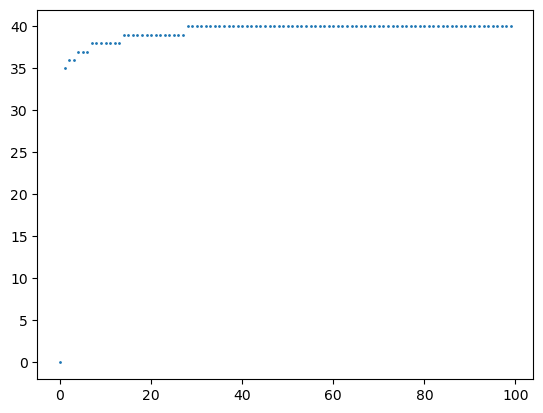

In [523]:
count_data = [f(x)[1] for x in np.linspace(0, 2, 100)]
plt.plot(count_data, 'o', markersize=1)

## Newton-Raphson módszer


,,Szép'' $f$ esetén keressük az $f(x)=0$ egyenlet megoldását. pl. ha $g$-t akarjuk invertálni az $y$ helyen, akkor 
$f(x) = g(x)-y$. Tegyük fel, hogy van egy kezdeti tippünk a megoldásra $x_0$. 
Ha $x_0$ nem megoldás, akkor módosítsuk:
$$
f(x_0+\Delta)= f(x_0)+ f'(x_0) \Delta +\text{hiba}
$$
Ha már közel vagyunk a megoldáshoz (a lineáris közelítés hibája kicsi, kisebb mint $f(x_0)$), akkor $\Delta = -f(x_0)/f'(x_0)$ választással még közelebb kerülünk a keresett értékhez.
$$
    x_{n+1} =  x_n -\frac{f(x_n)}{f'(x_n)}
$$
Pl. Ha a fenti $g$ függvényt nézzük, akkor $f(x) = g(x)-y$, $f'(x)=g'(x)=\arctan(x)+\frac{x}{1+x^2}$.

A derivált $x=0$-ban eltűnik, de ha $f(x)=0$ és $x_0\geq x$, akkor $x_n\geq x$ minden $n$-re, így ez nem okozhat gondot ha $y>0$ 
$$
\frac{f(x)}{f'(x)}=\frac{x\arctan(x)-y}{\arctan(x)+\frac{x}{1+x^2}}
$$
Míg $y=0$ esetén 
$$
\frac{f(x)}{f'(x)}=\frac{x\arctan(x)}{\arctan(x)+\frac{x}{1+x^2}}\to 0 \quad\text{ha $x\to0$}
$$
 

In [556]:
def f_NR(x, cond = lambda: True):
    y = x
    z = 1+ max(y-g(1), 0) * 2
    while (g(z)>y) and cond():
        deltaf = g(z)-y 
        df = math.atan(z)+z/(1+z*z)
        z = z-deltaf/df
    return z


In [561]:
cnt = Count()
print(g(f_NR(0.0001, cnt)))
cnt.cnt

0.0001


11

## Korábbi szorgalmi feladat.

Harmonikus sor alatt, az $\sum_{n=1}^\infty
  \frac1n$ sort értjük. Ennek a részletösszegeit szeretnénk kiszámítani
legalább $10^{-8}$ pontossággal. Ehhez használhatnánk, a definíciót:
```{python}
def harmonic_sum_slow(n: int) -> float:
    return sum(1/k for k in reversed(range(1, n+1)))
```

azonban ez túlságosan lassú. A művelet igény lineáris $n$-ben és
körülbelül $n=25*10^6$ esetén már egy másodperc körüli a futási idő.

A kiindulást a következő ötlet szolgáltathatja, $n\geq 1$-re:
$$
\begin{aligned}
    \log\left({n+\frac12}\right) - \log\left({n-\frac12}\right)
    &=\int_{n-\frac1{2}}^{n+\frac1{2}} \frac1{x} dx\\
    &= \int_{-\frac1{2}}^{\frac1{2}} \frac1{n+x} dx\\
    & = \frac1n +\int_{-\frac1{2}}^{\frac1{2}} \frac1{(n+x)}
      -\frac1ndx\\
    & = \frac1n +\int_{-\frac1{2}}^{\frac1{2}} \frac{x}{(n+x)n}dx\\
    & = \frac1n +\int_{0}^{\frac1{2}} \frac{2x^2}{(n^2-x^2)n}dx    
\end{aligned}
$$ Ebből becsüljük meg $\frac1n$ és a bal oldal eltérését.
Végül az összeg első néhány tagját megtartva, a többit közelítve a
logaritmus megváltozásával próbáljunk gyorsabb és az előírt pontosságú
módszert találni.

Egy másik lehetőség $1/n+1/(n+1)$ és $2\log(1+1/n)$ összehasonlítása.

In [259]:
def harmonic_sum_slow(n: int) -> float:
    return sum(1/k for k in reversed(range(1, n+1)))

In [264]:
%%time
harmonic_sum_slow(25*(10**6))

CPU times: user 1.01 s, sys: 0 ns, total: 1.01 s
Wall time: 1.01 s


17.611602067734673

A megadott formula alapján
$$
\begin{aligned}
\left|\frac1n - \int_{n-1/2}^{n+1/2} \frac1{x}dx\right| 
&= \int_0^{1/2} \frac{2x^2}{(n^2-x^2)n}dx\\
&\leq \frac1{(n^2-1)n}\int_0^{1/2} 2x^2dx=\frac1{12(n^2-1)n}
\end{aligned}
$$
Ha $n_0$-tól összegzünk, akkor
$$
\begin{aligned}
\sum_{n=n_0}^\infty \frac1{(n^2-1)n}& =
\sum_{n=n_0}^\infty \frac1{(n-1)(n+1)n}\\
&= \frac12\sum_{n=n_0}^\infty \frac1{n-1}+\frac1{n+1} -\frac{2}{n}\\
&=\frac12\left\{\sum_{n=n_0-1}\frac{1}{n}+\sum_{n=n_0+1}\frac1n-2\sum_{n=n_0}\frac1n\right\}\\
&=\frac12\left\{\frac1{n_0-1}-\frac1{n_0}\right\}=\frac{1}{2n_0(n_0-1)}
\end{aligned}
$$

Ebből az adódik, hogy
$$
\left|\sum_{n=n_0}^{n_1} \frac1n - \log\left(\frac{n_1+1/2}{n_0-1/2}\right)\right|
\leq \frac{1}{24(n_0(n_0-1))}
$$

A logaritmus értékét pontosnak vehetjük, így a közelítés hibája akkor lesz kisebb, mint $10^{-8}$, ha
$$
    24*n_0(n_0-1)>10^8 
$$

In [273]:
print(f"{((1e8)/24)**0.5=}")
n0 = 2500 


((1e8)/24)**0.5=2041.241452319315


In [276]:
import math

def harmonic_sum_faster(n: int) -> float:
    n0 = min(n, 2500)
    return sum(1/k for k in reversed(range(1, n0+1))) + math.log((n+0.5)/(n0+0.5))

In [281]:
%%ipytest

def test_hs():
    for n in range(1, 1000):
        assert harmonic_sum_slow(n) == harmonic_sum_faster(n) 

    for n in range(5000, 100_001, 2_500):
        assert abs(harmonic_sum_slow(n)-harmonic_sum_faster(n))<1e-8

    for n in range(500_000, 1_000_001, 50_000):
        assert abs(harmonic_sum_slow(n)-harmonic_sum_faster(n))<1e-8


.                                                                                            [100%]
1 passed in 0.47s


In [278]:
%%time
harmonic_sum_faster(10**8)

CPU times: user 72 µs, sys: 62 µs, total: 134 µs
Wall time: 141 µs


18.997896420517897

Lehet-e az eljárást iterálni?

Kicsit messzebbről ránézve a feladatra. Adott $g_0$ ,,szép'' függvény és keressük $\sum_{n=n_0}^{n_1} g_0(n)$ közelítését.
Ehhez $g_0(n)$-et $\int_{-1/2}^{1/2} g_0(x)dx$-et hasonlítjuk össze.

Legyen $w\equiv1$, $g(x)=g_0(x+n)$. A közelítés hibája:
$$
\begin{aligned}
    \int_{-1/2}^{1/2} w(x) (g(x)-g(0)) dx 
    &= \int_0^{1/2} w(x) (g(x)-g(0)+(g(-x)-g(0)))dx\\
    &=\int_0^{1/2} w(x)\int_0^x g'(y)-g'(-y) dy dx\\
    &=\int_0^{1/2} \int_y^{1/2} w(x)dx (g'(y)-g'(-y))dy\\
    &=\int_0^{1/2} w_1(y) \int_0^y (g''(z)+g''(-z))dz\\
    &=\int_0^{1/2} \int_z^{1/2} w_1(y)dy (g''(z)+g''(-z)) dz\\
    &=\int_{-1/2}^{1/2} w_2(z) g''(z) dz
\end{aligned}
$$
ahol $w_1$, $w_2$ páros függvények $w_{i+1}(x)=\int_x^{1/2} w_i(y)dy$, ha $x\in[0,1/2]$.
Pl. 
$$
w_0=1,\quad w_1(x)=\int_x^{1/2} 1 dy=1/2-x,\quad w_2(x)=\int_x^{1/2}(1/2-y) dy=\frac{(1/2-x)^2}{2}
$$
Általában $w_i(x)=(1/2-x)^{i}/{i!}$

Jelölje $\bar w_i$ a $w_i$ integrálját
$$
\begin{aligned}
\int_{-1/2}^{1/2} w_2(z) g''(z) dz &=
\bar{w_2}\int_{-1/2}^{1/2}  g''(z) dz+ \int_{-1/2}^{1/2} (w_2(z)-\bar{w_2}) (g''(z)-g''(0)) dz\\
&=
\bar{w_2}\int_{-1/2}^{1/2}  g''(z) dz+ \int_{-1/2}^{1/2} (w_4(z)-\bar{w_2}w_2(z)) g^{(4)}(z) dz\\
&=
\sum_{k=1}^K c_{2k}\int_{-1/2}^{1/2}  g^{(2k)}(z) dz + 
\int_{-1/2}^{1/2} v_{2K+2}(z) g^{(2K+2)}(z) dz.
\end{aligned}
$$

Mik a megjelenő konstansok?
$$
\begin{aligned}
w_k(x)&=\frac{(1/2-x)^{k}}{k!},\quad\bar{w_k}=\int_{-1/2}^{1/2} w_k(x)dx =2 w_{k+1}(0)=\frac{1}{2^{k} (k+1)!}\\
v_2 &= w_2,\quad c_2=\bar{w}_2,\quad v_4=w_4-c_2w_2
\end{aligned}
$$
Általában:
$$
\begin{aligned}
v_{2k} &= w_{2k} - c_2 w_{2(k-1)} -\cdots - c_{2(k-1)}w_2\\
c_{2k} &= \bar{w}_{2k} - c_2 \bar{w}_{2(k-1)} -\cdots - c_{2(k-1)}\bar{w}_2
\end{aligned} 
$$

Összefoglalva:

$$
\left|\sum_{n=n_0}^{n_1} g(n)-\sum_{k=0}^{K} c_{2k}\int_{n_0-{1/2}}^{n_1+{1/2}} g^{(2k)}(x)dx\right|\leq 
\left|\sum_{n=n_0}^{n_1} \int_{-{1/2}}^{1/2} {v_{2K+2}(z)} g^{2(K+1)}(z+n)dz\right|\leq\max |v_{2K+2}| \int_{n_0-1/2}^{n_1+1/2} |g^{(2K+2)} (z)|dz.
$$

$\max v_{2k}$-t is tudjuk becsülni:
$$
\begin{aligned}
\max |v_{2k}|
&= \max\left|w_{2k} - c_2 w_{2(k-1)} -\cdots - c_{2(k-1)}w_2\right|\\
&\leq w_{2k}(0) + |c_2 |w_{2(k-1)}(0) +\cdots + |c_{2(k-1)}|w_2(0) \\
&=\frac12(\bar{w}_{2k-1} + |c_2| \bar{w}_{2(k-1)-1} +\cdots + |c_{2(k-1)}| \bar{w}_1)
\end{aligned}
$$


In [574]:
from itertools import islice
import math 
import pandas as pd

def barw(k):
    return 1/((2**k) * math.factorial(k+1))

def c_seq():
    c = [1/24]
    while True:
        yield c[-1]
        k = len(c)
        c0 = sum(ci*barw(2*i) for i, ci in enumerate(reversed(c), 1))
        c.append(barw(2*(k+1))-c0)
    
def c_values(n):
    return list(islice(c_seq(), n))

def max_v(c):
    k = len(c)
    c0 = sum(abs(ci)*barw(2*i-1) for i, ci in enumerate(reversed(c), 1))
    return 0.5*(barw(2*k+1)+c0)

n0 = 5
c = c_values(20)
df = pd.DataFrame(
    {
        'c_k': c,
        'max_v': [max_v(c[:k]) for k in range(1,len(c)+1)]
    }
)
df['k'] = [2*i for i in range(1, len(df)+1)]
df['r_k'] = df.max_v*df.k.apply(lambda k: math.factorial(k)*((n0+0.5)**(-k+1)))
df
#print(max_v(c)*math.factorial(2*k)*((10+.5)**(-(2*k+1))))



,c_k,max_v,k,r_k
0,4.166667e-02,7.812500e-03,2,2.840909e-03
1,-1.215278e-03,2.821181e-04,4,4.069622e-05
2,3.203538e-05,8.170315e-06,6,1.168847e-06
3,-8.202608e-07,2.166371e-07,8,5.737393e-08
4,2.083598e-08,5.565266e-09,10,4.385153e-09
5,-5.281610e-10,1.415339e-10,12,4.866401e-10
6,1.338090e-11,3.588940e-12,14,7.424370e-11
7,-3.389577e-13,9.093421e-14,16,1.492473e-11
8,8.585997e-15,2.303554e-15,18,3.824491e-12
9,-2.174865e-16,5.835074e-17,20,1.216970e-12


In [337]:
def harmonic_sum_fast(n: int) -> float:
    n0 = min(n, 10)
    c = c_values(5)
    result = sum(1/k for k in reversed(range(1, n0+1))) + math.log((n+0.5)/(n0+0.5))
    for i, ci in enumerate(c, 1):
        k = 2*i
        result += ci * math.factorial(k-1)*((n+0.5)**(-k) -(n0+0.5)**(-k))  
    return  result

def mk_harmonic_mean(N0=10, K=5):
    c = c_values(K)

    def harmonic_sum(n: int) -> float:
        n0 = min(n, N0)
        result = sum(1/k for k in reversed(range(1, n0+1))) + math.log((n+0.5)/(n0+0.5))
        factorial = 1
        a0 = a = 1/((n+0.5)*(n+0.5))
        b0 = b = 1/((n0+0.5)*(n0+0.5))
        for i, ci in enumerate(c, 1):
            result += ci * factorial*(a - b)
            factorial *= (2*i)*(2*i+1)
            a *= a0
            b *= b0
             
        return  result

    return harmonic_sum

harmonic_sum = mk_harmonic_mean(N0=10, K=5)

In [338]:
%%ipytest

def test_hs2():
    for n in range(1, 1000):
        assert abs(harmonic_sum_slow(n) - harmonic_sum_fast(n))<1e-8 

    for n in range(5000, 100_001, 2_500):
        assert abs(harmonic_sum_slow(n)-harmonic_sum_fast(n))<1e-8

    for n in range(500_000, 1_000_001, 50_000):
        assert abs(harmonic_sum_slow(n)-harmonic_sum_fast(n))<1e-8


def test_hs3():
    for n in range(1, 1000):
        assert abs(harmonic_sum_slow(n) - harmonic_sum(n))<1e-8 

    for n in range(5000, 100_001, 2_500):
        assert abs(harmonic_sum_slow(n)-harmonic_sum(n))<1e-8

    for n in range(500_000, 1_000_001, 50_000):
        assert abs(harmonic_sum_slow(n)-harmonic_sum(n))<1e-8


..                                                                                           [100%]
2 passed in 0.91s


In [339]:
%%time
harmonic_sum_fast(10**8)

CPU times: user 27 µs, sys: 21 µs, total: 48 µs
Wall time: 51 µs


18.997896413853887

In [341]:
%%time
harmonic_sum(10**8)

CPU times: user 16 µs, sys: 13 µs, total: 29 µs
Wall time: 32.9 µs


18.997896413853887

# `with` statement


 
## Mi történik a `with` statement alkalmazásakor?

### Mit lehet a with mögé írni?

Hasonlóan a `for`-hoz szinte bármit, aminek van két metódusa:

- `__enter__`
- `__exit__`


    with obj as x:
       do_something with x

Itt az `obj.__enter__()` hívás eredménye lesz az x értéke és a block végén **GARANTÁLTAN** végrehajtódik az `obj.__exit__(...)` hívás.
Az `__enter__` metódus végezheti az előkészítést, az `__exit__` a takarítást!

#### Kell-e nekünk ezeket a metódusokat közvetlenül implementálni?

Valójában nem. Elegendő egy generátor függvényt megírni:

    import time
    
    def timer():
        try:
            start = time.time()
            yield

        finally:
            runtime = time.time() - start
            print(f"run time: {runtime:3f}")
            

Így még csak egy generátort kapunk ami egyszer visszaad semmit (`None`) majd jelzi, hogy vége van a sorozatnak. 

Próbáljuk ki `for`-ral

In [ ]:
import time
    
def timer():
    try:
        start = time.time()
        yield

    finally:
        runtime = time.time() - start
        print(f"run time: {runtime:3f}")
        
for x in timer():
    print(x)

`with`-del hibát kapunk

In [ ]:
with timer() as x:
    print(x)

A `contextlib` module `contextmanager` függvénye generátorból `contextmanager`-t készít.

In [ ]:
from contextlib import contextmanager
timer2 = contextmanager(timer)
with timer2() as x:
    print(x)

Ha egy függvény akarunk alkalmazni egy függvényre, hogy azt átalakítsuk, de ugyanaz maradjon a neve akkor a python `@` szintakszist használja. Ilyenkor ,,dekoráljuk'' a függvényt. A `contextmanager` egy példa **dekorátor**ra.

    @contextmanager
    def timer():
        try:
            start = time.time()
            yield

        finally:
            runtime = time.time() - start
            print(f"run time: {runtime:3f}")
    
Példaként írjunk egy olyan contextmanager-t, ami jelzi nekünk, hogy mikor milyen hívás történik.

In [ ]:
@contextmanager
def print_whats_going_on(x):
    print("try blokk előtt")
    try:
        print("yield előtt")
        yield x
        print("yield után")
    except:
        print("except ág")
    finally:
        print("finally ág")
    print("try blokk után")

In [ ]:
with print_whats_going_on("hello") as x:
    print(x)
print("with után")

print("-"*50)

with print_whats_going_on("hello") as x:
    print(x)
    raise ValueError
print("with után")


In [ ]:
@contextmanager
def timer():
    try:
        start = time.time()
        yield

    finally:
        runtime = time.time() - start
        print(f"run time: {runtime:3f}")

In [ ]:
t = timer()
with t:
    time.sleep(0.5)

Használhatjuk-e többször a `timer`-ünket?

In [ ]:
t = timer()
with t:
    time.sleep(0.5)
with t:
    time.sleep(0.5)


## Tudunk-e olyan contextmanagert készíteni, ami többször felhasználható?

pl.

```
with indented:
    indented.print("első")
    with indented:
        indented.print("második")
    indented.print("harmadik")
```

ahol kimenetként azt várnánk, hogy
```
  első
    második
  harmadik
```

In [ ]:
class Indent:
    def __init__(self, indent='  '):
        self.level = 0
        self.indent = indent
    
    def __enter__(self):
        self.level += 1
        return None
    
    def __exit__(self, *args):
        self.level -= 1
    
    def print(self, x):
        indent = self.indent*self.level 
        x = str(x)
        print('\n'.join(indent+line for line in x.split('\n')))


In [ ]:
indented = Indent('...')
text = """Többsoros szöveg:
Első
Második
"""
with indented:
    indented.print("első")
    with indented:
        indented.print("második")
        with indented:
            indented.print(text)
    indented.print("harmadik")

# Feladatok előadásról

Előadáson a föld népességének alakulása szerepelt egy [Kaggle](https://www.kaggle.com) adathalmazon. Mi a 
[https://www.gapminder.org/data/] oldalról származó adatokat fogjuk használni. 

FREE DATA FROM WORLD BANK VIA GAPMINDER.ORG, CC-BY LICENSE

Felmásoltam őket az óra github repojára, a letöltési címek:


In [ ]:
csv_files = {
    "income": "income_per_person_gdppercapita_ppp_inflation_adjusted.csv",
    "life_expectancy": "life_expectancy_years.csv",
    "population": "population_total.csv"
}
regions_url = "http://gapm.io/dl_geo"

baseurl = "https://github.com/prokaj/elte-python/raw/main/"

## Kérdések előadásról:

* Melyek a Föld legsűrűbben lakott országai?
* Melyek a legritkábban lakott országok?
* Földrészenként melyik a három legritkábban lakott ország?
* Melyik földrész népessége nőtt a legtöbbet 1970 óta?

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px

In [ ]:

gapminder = px.data.gapminder()
gapminder


In [ ]:
print(gapminder.describe())
print(gapminder.info())


In [ ]:
px.scatter(data_frame= gapminder,
           x= "gdpPercap",
           y="lifeExp", 
           animation_frame="year",
           animation_group="country",
           size="pop", 
           color="continent", 
           hover_name="country",
           log_x=True, 
           size_max=55, 
           range_x=[100, 100000], 
           range_y=[25,90])

Részletesebb adatok:

In [ ]:

url = baseurl+csv_files['income']
print(url)
df = pd.read_csv(url, dtype=str)
df.head()

In [ ]:
from collections import defaultdict
col_types = defaultdict(list)
for col in df.columns:
    col_types[str(df[[col]].values.dtype)].append(col)

print(dict(col_types))
    


## Feladat.

Olvassuk be az adatokat és válaszoljuk meg a fenti kérdéseket: 

* Melyek a Föld legsűrűbben lakott országai?
* Melyek a legritkábban lakott országok?
* Földrészenként melyik a három legritkábban lakott ország?
* Melyik földrész népessége nőtt a legtöbbet 1970 óta?

# Conway Game of Life


The Game of Life is a cellular automaton created by mathematician John Conway in 1970. The game consists of a board of cells that are either on or off. One creates an initial configuration of these on/off states and observes how it evolves. There are four simple rules to determine the next state of the game board, given the current state:

- **Overpopulation**: if a living cell is surrounded by more than three living cells, it dies.
- **Stasis**: if a living cell is surrounded by two or three living cells, it survives.
- **Underpopulation**: if a living cell is surrounded by fewer than two living cells, it dies.
- **Reproduction**: if a dead cell is surrounded by exactly three cells, it becomes a live cell.


Írjunk egy osztályt a játékhoz, pl. az `__init__` metódus hozzalétre a megadott konfigurációnak megfelelő objektumot. Legyen egy `step` metódus, ami a rendszert a következő állapotába viszi és az `__str__` metódus pedig
valahogy ábrázolja az aktuális állapotot. 

Tegyük fel, hogy a rács amin a rendszer él, egy $n\times n$-es rács, ahol mindkét irányban ciklikusan körbemegyünk,
azaz a csúcsokat modulo $n$ tekintjük.


In [ ]:
class ConwayGoL:
    
    def __init__(self, state):
        self.state = list(state)

    def step(self):
        return self

    def __repr__(self):
        return f"{type(self).__name__}({self.state})"

In [ ]:
import random

init_state = [] ## ???
conway = ConwayGoL(init_state)

conway.step()


A játék állapotának leírásához egy $n\times n$ rács minden pontjáról tudni kell, hogy foglalt-e vagy sem.

```
n = 11
state = [[0]*n for _ in range(n)]
```

Véletlenszerű kezdeti állapot:
```
state = [[random.randint(0,1) for _ in range(n)] for _ in range(n)]
```

In [ ]:
def random_state(n, m, p):
    return [[int(random.random()<p) for _ in range(m)] for _ in range(n)]

state = random_state(11, 25, 0.2)
print(state)

Szebb megjelenítés?

In [ ]:
def as_matrix(lst, n):
    return [lst[i:i+n] for i in range(0, len(lst), n)]

print('\n'.join(''.join(map(str, line)) for line in state))


In [ ]:
symbols = "\u2b1c\u2b1b"
print('\n'.join(''.join(symbols[x] for x in line) for line in state))


In [ ]:
import matplotlib.pyplot as plt 

img = plt.matshow(state, cmap="viridis")
#img.axes.axis(False)
n, m = len(state), len(state[0])
for pos in range(0, n+1):
    img.axes.axhline(y=pos-0.5, color="white")
for pos in range(0, m+1):
    img.axes.axvline(x=pos-0.5, color="white")

plt.show()


In [ ]:

def cgol_str(self):
    symbols = "\u2b1c\u2b1b"
    return '\n'.join(''.join(symbols[x] for x in line) for line in self.state)

ConwayGoL.__str__ = cgol_str

    

In [ ]:
conway = ConwayGoL(state)
print(conway)

A `step` metódushoz ki kellene számolni egy adott csúcs foglalt szomszédainak számát `cnt`. Ha ez kész,
akkor az $i$ csúcs új állapota:

$$
    \text{state}_{t+1}[i]=
    \begin{cases}
    1 &\text{Ha $\text{cnt}[i]\in\{2,3\}$ és $\text{state}_t[i]=1$}\\
    1 &\text{Ha $\text{cnt}[i]\in\{3\}$ és $\text{state}_t[i]=0$}\\
    0 &\text{különben}
    \end{cases}
$$

In [ ]:
def newstate(state, count):
    return [int((c==3)|((c==2) & (s==1))) for s, c in  zip(state, count)]

In [ ]:
%%ipytest

def test_newstate():
    res = [0]*9
    res[2] = 1
    res[3] = 1
    assert newstate([1]*9, list(range(9))) == res
    res = [0]*9
    res[3] = 1    
    assert newstate([0]*9, list(range(9))) == res


In [ ]:
def count_neighbors(state):
    strides = [(0,-1), (0, 1), (1,-1), (1,0), (1,1), (-1,-1), (-1,0), (-1,1)] 
    n, m = len(state), len(state[0])
    return [ [sum(state[(i+di) % n][(j+dj) % m] for di, dj in strides) for j in range(m)] for i in range(n)]

def cgol_step(self):
    counts = count_neighbors(self.state)
    self.state = [ newstate(line, cnt) for line, cnt in zip(self.state, counts) ]
    return self
    
ConwayGoL.step = cgol_step

In [ ]:
@classmethod
def cgol_from_random_state(cls, n, m,  p):
    return cls(random_state(n, m, p))

ConwayGoL.from_random_state=cgol_from_random_state

In [ ]:
conway = ConwayGoL.from_random_state(4, 4, 0.3)
print(conway)
print(count_neighbors(conway.state))

In [ ]:
conway = ConwayGoL.from_random_state(5, 5, 0.5)
print(conway)
print("-"*20)
print(conway.step())

Tudunk-e valami animációszerűt készíteni? Jupyter notebook-ban pl. a következő képpen lehet: 

In [ ]:
from ipywidgets import Output
from time import sleep

out = Output()
display(out)
conway = ConwayGoL.from_random_state(n=31, m=55, p=0.2)

for i in range(100):
    out.clear_output(True)
    with out:
        print(f"After {i} steps:\n{conway}")  
    sleep(0.2)
    conway.step()


Ha parancssorból dolgozunk, akkor valami ilyesmit lehetne tenni

In [ ]:
%%writefile conway.py

import random


def random_state(n, m, p):
    return [ [ int(random.random()<p) for _ in range(m) ] for _ in range(n) ]

def count_neighbors(state):
    strides = [(0,-1), (0, 1), (1,-1), (1,0), (1,1), (-1,-1), (-1,0), (-1,1)] 
    n, m = len(state), len(state[0])
    return [ [sum(state[(i+di) % n][(j+dj) % m] for di, dj in strides) for j in range(m)] for i in range(n)]

def newstate(state, count):
    return [int((c==3)|((c==2) & (s==1))) for s, c in  zip(state, count)]

class ConwayGoL:
    symbols = "\u2b1c\u2b1b"
    
    def __init__(self, state):
        self.state = list(state)
        
    def step(self):
        counts = count_neighbors(self.state)
        self.state = [ newstate(line, cnt) for line, cnt in zip(self.state, counts) ]
        return self

    
    def __str__(self): 
        symbols = self.symbols
        return '\n'.join(''.join(symbols[x] for x in line) for line in self.state)

    def __repr__(self):
        return f"{type(self).__name__}({self.state})"
    
    @classmethod
    def from_random_state(cls, n, m, p):
        return cls(random_state(n, m, p))

    def is_empty(self):
        return not any(any(line) for line in self.state)


def clear_terminal(n):
    print(f"{chr(27)}[{n+1}A", end="")

def main(n=11, m=25, p=0.2, nsteps=10, clear_screen=clear_terminal):
    from time import sleep
    conway = ConwayGoL.from_random_state(n, m, p)
    for i in range(nsteps+1):
        if i>0:
            clear_screen(n)
        print(f"after {i} step:")
        print(conway)  
        sleep(0.2)
        conway.step()
        if conway.is_empty():
            break
    
if __name__ == "__main__":
    main()
    

Ha valamit már megírtunk és szeretnénk használni, `import`-tal elérhető. Pl.

### Tudunk-e paramétereket adni a python scriptnek?

Amikor egy python scriptet futtatunk, a parancssor (amivel a futást indítottuk) a `sys` modul `argv` változójában érhető el.

In [ ]:
import sys
sys.argv

In [ ]:
! python -c 'import sys; print(sys.argv)' -alma


Egy nagyon egyszerű megoldás, ha minden opciónak a neve a paraméter amit beállít és egyenlőségjel után az értéke:
pl. n=11 m=25 nstep=10 p=0.2

In [ ]:
cmdline = "conway.py -n=11 -m=25 -nstep=10 -p=0.2"
argv = cmdline.split()
params =[param.split("=") for param in argv[1:]]
params

Minden paraméterről tudni kellene, hogy milyen típusú!

In [ ]:
param_types={'-n': int, '-m': int, '-nstep': int, '-p': float}
params = {k.replace("-",""): param_types[k](v)  for k, v in (param.split("=") for param in argv[1:])}
params

Ezek után a `main` függvényt a megadott paraméterekkel meg tudjuk hívni:

```
    main(**params)
```
Mi van a `default` értékekkel, `help`-pel stb.

Ezeket mind meg tudnánk írni, de nem kell. Van kész megoldás `python`-ban.

Az `argparse` könvytár mindent megcsinál, ami nekünk kell.

In [ ]:
import argparse

help(argparse)

A `conway.py` file végét cseréljük le erre.
```
if __name__=="__main__":

    import argparse
    
    parser = argparse.ArgumentParser(description='Conways Game of Life')

    parser.add_argument(
        '-n', '--nrows', 
        type=int, 
        default=11, 
        help='number of rows'
        )

    parser.add_argument(
        '-m', '--ncols',
        type=int, 
        default=25, 
        help='number of columns'
        )

    parser.add_argument(
        '-p', '--density',
        type=float, 
        default=0.2,
        help='initial density')
    
    parser.add_argument(
        '--nsteps', 
        type=int, 
        default=10, 
        help='steps to display'
        )

    args = parser.parse_args()
    
    main(n=args.n, m=args.m, p=args.p, nsteps=args.nsteps)
```
    

In [ ]:
# import importlib
# importlib.reload(conway)

In [ ]:
import conway

out1 = Output()
display(out1)

with out1:
    conway.main(clear_screen=lambda n: out1.clear_output(True))

Az `argparse` könyvtár nem a legkényelmesebb. Alternatívák:

- [Docopt](http://docopt.org/)
- [Click](https://pypi.org/project/click/)
- [clize](https://github.com/epsy/clize)

és még sok másik is!

## Itt is használhattunk volna dekorátort


A `ConwayGoL` példában utólag adtunk metódusokat az osztályunkhoz. Ezt is megtehettük volna dekorátorral.  

In [ ]:
def conway_method(f):
    setattr(ConwayGoL, f.__name__, f)
    return f


@conway_method
def dummy_method(self):
    print("this is a message from the new method!")

c = ConwayGoL([], 0)
c.dummy_method()

Azt is megtehettük volna, hogy a osztály nincs beleégetve a kódba.

In [ ]:
def new_method(cls):
    def decorator(f):
        setattr(cls, f.__name__, f)
        return f 
    return decorator

@new_method(ConwayGoL)
def dummy_method(self):
    print("Note that the old value of dummy_method is overwritten!")

In [ ]:
c.dummy_method()

# További feladatok a félév során

- Character RNN Arany összesre

- MNIST 

- Első előadás bevezető példái (arc, hangulat felismerés)

- Prím számok eloszlása
